In [1]:
import torch
import torch.nn as nn

import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
sys.path.append('/workspace/experiment')
from data.cifar10 import SplitCifar10, train_transform, val_transform
from data.capsule_split import get_splits

import os

import matplotlib.pyplot as plt
from glob import glob

In [66]:
# log_dir = "/workspace/experiment/log/NoiseGeneration/cifar10_s0/14"
log_dir = '/workspace/experiment/result/checkpoints/s2-1-cifar10-s1-v7.ckpt'
glob(log_dir + "/*")

[]

In [67]:
checkpoint = torch.load(log_dir)

In [68]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.05)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
def cal_index(num_classes, y):
        batch_size = y.size(0)
        new_index = torch.randperm(batch_size).type_as(y)
        newY = y[new_index]
        mask = (newY == y)
        while mask.any().item():
            newY[mask] = torch.randint(0, num_classes, (torch.sum(mask),)).type_as(y)
            mask = (newY == y)
        return newY
        
class NoiseEncoder(nn.Module):
    def __init__(self, 
                 channel_in:  int,
                 channel_out: int,
                 kernel_size: int,
                 stride:      int,
                 padding:     int,
                 bias:        bool=False, 
                 num_classes: int=6,
                 alpha: float=1.0):
        
        super(self.__class__, self).__init__()
        self.conv = nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=bias)
        self.bn = nn.BatchNorm2d(channel_out)
        self.bn_noise = nn.BatchNorm2d(channel_out)
        self.activation = nn.LeakyReLU(0.2)
        self.num_classes = num_classes
        self.register_buffer('buffer', None)
        self.alpha = alpha
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x
    
    def forward_clean(self, x, y, class_mask):
        newY = cal_index(self.num_classes, y)
        x = self.conv(x)
        self.cal_class_per_std(x, class_mask)
        noise = torch.normal(mean=0, std=self.buffer[newY]).type_as(x)
        x_n = x.detach().clone() + self.alpha * noise
        x = self.bn(x)
        x = self.activation(x)
        
        x_n = self.bn(x_n)
        x_n = self.activation(x_n)
        return x, x_n
        
    def forward_noise(self, x, newY):
        x = self.conv(x)
        x = x + self.alpha * torch.normal(mean=0, std=self.buffer[newY]).type_as(x)
        x = self.bn_noise(x)
        x = self.activation(x)
        return x
    
    def cal_class_per_std(self, x, idxs):
        std = []
        for i in range(self.num_classes):
            x_ = x[idxs[i]].detach().clone()
            
            std.append(x_.std(0))
        self.buffer = torch.stack(std)

class classifier32(nn.Module):
    def __init__(self, num_classes=2, **kwargs):
        super(self.__class__, self).__init__()
        self.num_classes = num_classes
        self.num_classes = num_classes
        
        self.conv1 = NoiseEncoder(3,     64,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv2 = NoiseEncoder(64,    64,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv3 = NoiseEncoder(64,   128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.conv4 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv5 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv6 = NoiseEncoder(128,  128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.conv7 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv8 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv9 = NoiseEncoder(128,  128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.fc = nn.Linear(128, num_classes + 1)
        self.dr1 = nn.Dropout2d(0.2)
        self.dr2 = nn.Dropout2d(0.2)
        self.dr3 = nn.Dropout2d(0.2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.apply(weights_init)
        
    def forward(self, x):
        l1 = self.block1(x)
        l2 = self.block2(l1)
        y = self.block3(l2)
        
        
        return y
        
    def block1(self, x):
        x = self.dr1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        return x
    
    def block1_n(self, x, y):
        class_mask = y.unsqueeze(0) == torch.arange(
            self.num_classes).type_as(y).unsqueeze(1)
        x = self.dr1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        clean, noise = self.conv3.forward_clean(x, y, class_mask)
        return clean, noise
    
    def block2(self, x):
        x = self.dr2(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        return x
    
    def block2_n(self, x, y):
        class_mask = y.unsqueeze(0) == torch.arange(
            self.num_classes).type_as(y).unsqueeze(1)
        x = self.dr2(x)
        x = self.conv4(x)
        x = self.conv5(x)
        clean, noise = self.conv6.forward_clean(x, y, class_mask)
        return clean, noise

    def block3(self, x):
        x = self.dr3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)

        logit = self.fc(x)
        return logit
    
class Generator(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(self.__class__, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            )
        
    def forward(self, x):
        output = self.main(x)
        return output
    
class Discriminator(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(self.__class__, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channel, out_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(out_channel, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        output = self.main(x)
        output = self.avgpool(output)
        output = output.view(output.size(0), -1)
        output = self.classifier(output).flatten()
        output = self.activation(output)
        return output


In [69]:

model = classifier32(num_classes=6, alpha=0.1)
G = Generator(128, 128)
D = Discriminator(128, 128)
model_state_dict = model.state_dict()
G_state_dict = G.state_dict()
D_state_dict = D.state_dict()
for name, param in checkpoint['state_dict'].items():
    if name.startswith('model'):
        n = name.replace('model.', '')
        if n in model_state_dict.keys():
            model_state_dict[n].copy_(param)
    elif name.startswith('G'):
        n = name.replace('G.', '')
        if n in G_state_dict.keys():
            G_state_dict[n].copy_(param)
    elif name.startswith('D'):
        n = name.replace('D.', '')
        if n in D_state_dict.keys():
            D_state_dict[n].copy_(param)

In [72]:
split = get_splits('cifar10', 1)
known_data = SplitCifar10('/datasets', train=False, transform=val_transform, split=split['known_classes'])
open_data = SplitCifar10('/datasets', train=False, transform=val_transform, split=split['unknown_classes'])
known_loader = DataLoader(known_data, batch_size=32, shuffle=False, num_workers=4)
open_loader = DataLoader(open_data, batch_size=32, shuffle=False, num_workers=4)


In [73]:
test_input, test_target = next(iter(known_loader))
o_input, o_target = next(iter(open_loader))

In [74]:
model.eval()
model.cpu()
G.eval()
G.cpu()
D.eval()
D.cpu()
print()

In [75]:
l1, l1_n = model.block1_n(test_input, test_target)
fake_feature = G(l1_n)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

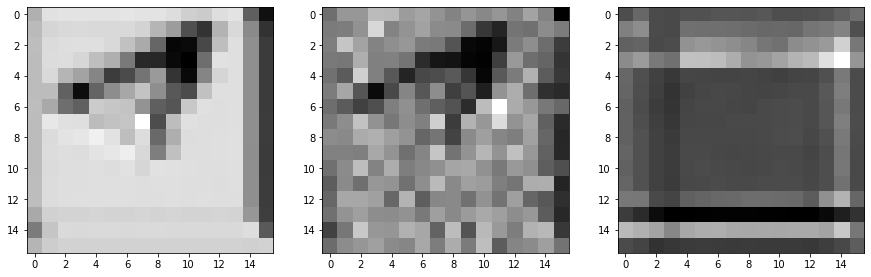

In [113]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
instance = 15
channel = 120

ax[0].imshow(l1[instance][channel].detach().cpu().numpy(),  cmap='gray')
ax[1].imshow(l1_n[instance][channel].detach().cpu().numpy(), cmap='gray')
ax[2].imshow(fake_feature[instance][channel].detach().cpu().numpy(), cmap='gray')
ax

TypeError: 'list' object is not callable

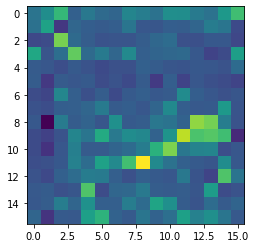

In [25]:
plt.imshow(l1_n[0][3].detach().cpu().numpy())

In [20]:
fake_feature = G(l1_n)

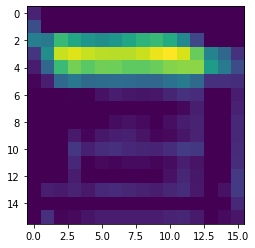

In [35]:
plt.imshow(fake_feature[0][2].detach().cpu().numpy())

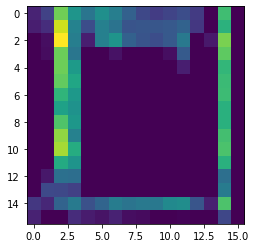

In [51]:
plt.imshow(fake_feature[7][13].detach().cpu().numpy())

In [87]:
l1[0][3].detach().cpu().numpy().min()

-0.4772651

In [88]:
fake_feature[0][3].detach().cpu().numpy().min()

-0.4010825